In [1]:
import pandas as pd
import matplotlib
from sklearn import preprocessing
%matplotlib inline

In [10]:
df = pd.read_csv('data/raw2.csv', low_memory=False)

In [11]:
#filter rows
nedf = df[(df.posteam==input) & (df.down.isin([1.0, 2.0, 3.0, 4.0])) & ((df.play_type=='run') | (df.play_type == 'pass'))]

In [12]:
#filter columns
nedf = nedf[['game_seconds_remaining', 'yardline_100', 'down', 'ydstogo', 'play_type', 'pass_length', 'pass_location', 'run_location']]

In [13]:
nedf

,game_seconds_remaining,yardline_100,down,ydstogo,play_type,pass_length,pass_location,run_location
2228,3399.0,61.0,1.0,10,pass,short,right,NaN
2229,3397.0,61.0,2.0,10,run,NaN,NaN,left
2230,3357.0,59.0,3.0,8,pass,short,middle,NaN
2240,3133.0,82.0,1.0,10,pass,deep,left,NaN
2241,3119.0,62.0,1.0,10,run,NaN,NaN,middle
...,...,...,...,...,...,...,...,...
447256,514.0,11.0,2.0,6,run,NaN,NaN,left
447257,465.0,11.0,3.0,6,pass,short,left,NaN
447269,184.0,92.0,1.0,10,run,NaN,NaN,left
447272,180.0,96.0,2.0,14,run,NaN,NaN,left


In [15]:
import numpy as np
def get_full_play_type(play):
    play_type, pass_location, run_location = play
    if(play_type == 'run'):
        return play_type+'_'+ run_location
    else:
        return play_type+'_'+ pass_location
nedf = nedf.replace(np.nan, 'unknown', regex=True)    
nedf['full_play_type'] = nedf[['play_type','pass_location', 'run_location']].apply(get_full_play_type, axis=1)
nedf = nedf[(nedf.full_play_type.isin(['pass_left', 'pass_middle','pass_right','run_left', 'run_middle', 'run_right']))]

In [16]:
nedf.groupby(['full_play_type']).count()[['play_type']]

,play_type
full_play_type,
pass_left,1837
pass_middle,1175
pass_right,2153
run_left,1765
run_middle,559
run_right,1694


<AxesSubplot:ylabel='full_play_type'>

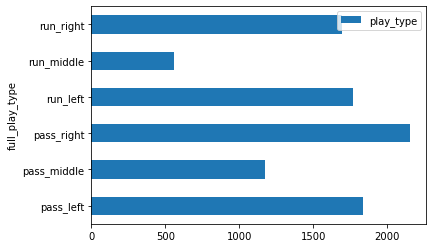

In [17]:
nedf.groupby(['full_play_type']).count()[['play_type']].plot(kind='barh')

In [18]:
nedf.groupby(['full_play_type']).count()[['play_type']].apply(lambda x:100 * x / float(x.sum()))

,play_type
full_play_type,
pass_left,20.004356
pass_middle,12.795383
pass_right,23.445497
run_left,19.220298
run_middle,6.087335
run_right,18.447131


In [19]:
le = preprocessing.LabelEncoder()
le.fit(nedf.full_play_type)
nedf['full_play_type_code'] = le.transform(nedf['full_play_type'])

<AxesSubplot:ylabel='full_play_type_code'>

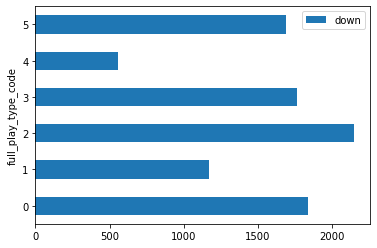

In [20]:
nedf.groupby(['full_play_type_code']).count()[['down']].plot(kind='barh')

In [21]:
def bucketize(val, size, count):
    i=0
    for i in range(count):
        if val <= (i+1)*size:
            return i
    return i
def bucketize_df(df):
    df['ydstogo'] = [bucketize(x, 4, 5) for x in df['ydstogo']]
    return df
nedf = bucketize_df(nedf)

In [22]:
nedf = pd.concat([nedf, pd.get_dummies(nedf['down'], prefix='down')], axis=1)
nedf = pd.concat([nedf, pd.get_dummies(nedf['ydstogo'], prefix='ydstogo')], axis=1)

In [23]:
nedf.describe()

,yardline_100,down,ydstogo,full_play_type_code,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,ydstogo_1,ydstogo_2,ydstogo_3,ydstogo_4
count,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000
mean,52.606011,1.777633,1.627790,2.339323,0.450506,0.335293,0.200261,0.013939,0.154198,0.187412,0.573233,0.046717,0.038441
std,24.680543,0.810646,0.930719,1.705650,0.497571,0.472119,0.400218,0.117243,0.361158,0.390263,0.494635,0.211043,0.192268
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,73.000000,2.000000,2.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,99.000000,4.000000,4.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
nedf['yardline_100']/=100

In [25]:
nedf.describe()

,yardline_100,down,ydstogo,full_play_type_code,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,ydstogo_1,ydstogo_2,ydstogo_3,ydstogo_4
count,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000,9183.000000
mean,0.526060,1.777633,1.627790,2.339323,0.450506,0.335293,0.200261,0.013939,0.154198,0.187412,0.573233,0.046717,0.038441
std,0.246805,0.810646,0.930719,1.705650,0.497571,0.472119,0.400218,0.117243,0.361158,0.390263,0.494635,0.211043,0.192268
min,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.350000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.560000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.730000,2.000000,2.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.990000,4.000000,4.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
#select important columns for input
X=nedf[['yardline_100', 'down', 'ydstogo', 'down_1.0', 'down_2.0', 'down_3.0', 'down_4.0','ydstogo_0','ydstogo_1','ydstogo_2','ydstogo_3','ydstogo_4']]
#select result column for output
Y=nedf['full_play_type_code']
#split data for train and test
train_x, test_x, train_y, test_y = train_test_split(X, Y, random_state = 0)

In [28]:
from sklearn.ensemble import RandomForestClassifier
the_clf=RandomForestClassifier(max_depth=8, n_estimators=64)
the_clf.fit(train_x, train_y)

RandomForestClassifier(max_depth=8, n_estimators=64)

In [29]:
from sklearn.metrics import accuracy_score, explained_variance_score
pred = the_clf.predict(test_x)
acc =accuracy_score(test_y, pred)
print(acc)

0.25435540069686413


In [30]:
eacc = explained_variance_score(test_y, pred)
print(eacc)

-0.35588706090270894


In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_y, pred)
import matplotlib.pyplot as plt

In [32]:
from sklearn.metrics import classification_report
pred = the_clf.predict(test_x)
target_names = ['Pass Left', 'Pass Middle', 'Pass Right','Run Left','Run Middle', 'Run Right']
print(classification_report(test_y, pred, target_names=target_names))

              precision    recall  f1-score   support

   Pass Left       0.25      0.14      0.18       441
 Pass Middle       0.34      0.06      0.10       302
  Pass Right       0.28      0.42      0.34       558
    Run Left       0.24      0.49      0.32       434
  Run Middle       0.00      0.00      0.00       140
   Run Right       0.21      0.14      0.16       421

    accuracy                           0.25      2296
   macro avg       0.22      0.21      0.18      2296
weighted avg       0.24      0.25      0.22      2296



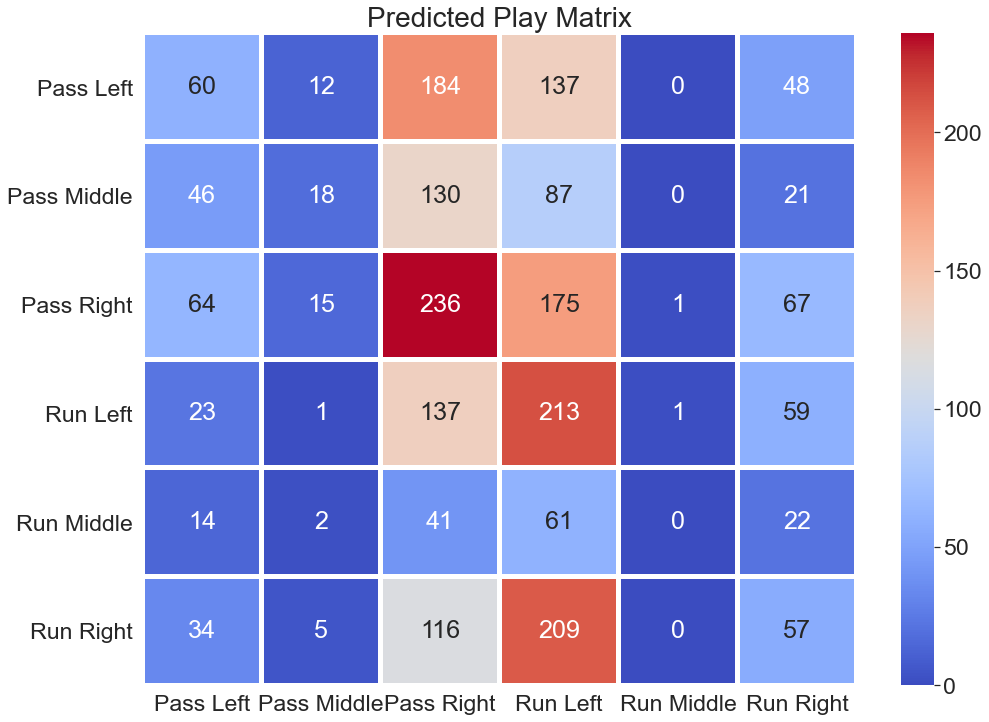

In [36]:
import seaborn as sns
plt.subplots(figsize=(16,12))
plt.title('Predicted Play Matrix', fontsize = 28) 
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
x_axis_labels = ['Pass Left', 'Pass Middle', 'Pass Right','Run Left','Run Middle', 'Run Right']
y_axis_labels = ['Pass Left', 'Pass Middle', 'Pass Right','Run Left','Run Middle', 'Run Right']
sns.set(font_scale=2.1)
sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cmap='coolwarm', annot=True, linewidths=4, fmt='g')
plt.savefig('ConfusionMatrixOutput/CM.png')